In [3]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    classification_report
)
from scipy.sparse import issparse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [46]:
# indir = '/content/gdrive/MyDrive/Colab Notebooks/Data/'
# X_train = indir + 'X_train.csv'
# X_test = indir + 'X_test.csv'
# y_train = indir + 'y_train.csv'
# y_test = indir + 'y_test.csv'

# # read the data sets
# X_train = pd.read_csv(X_train)
# X_test = pd.read_csv(X_test)
# y_train = pd.read_csv(y_train)
# y_test = pd.read_csv(y_test)

X_train = pd.read_csv("../../Data/X_train.csv")
X_test = pd.read_csv("../../Data/X_test.csv")
y_train = pd.read_csv("../../Data/y_train.csv")
y_test = pd.read_csv("../../Data/y_test.csv")

In [4]:
# indir = '../../Data/GoogleDrive/'
# X_train = indir + 'X_train.csv'
# X_test = indir + 'X_test.csv'
# y_train = indir + 'y_train.csv'
# y_test = indir + 'y_test.csv'

# # read the data sets
# X_train = pd.read_csv(X_train)
# X_test = pd.read_csv(X_test)
# y_train = pd.read_csv(y_train)
# y_test = pd.read_csv(y_test)

In [47]:
# drop the first column
X_train = X_train.iloc[:, 1:]
X_test = X_test.iloc[:, 1:]
y_train = y_train["HadHeartDisease"]
y_test = y_test["HadHeartDisease"]

# convert the y values to 1D array and 0,1 
y_train = pd.get_dummies(y_train, drop_first=True).astype(int)
y_test = pd.get_dummies(y_test, drop_first=True).astype(int)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
# threads = os.cpu_count() - 2



### Logistic Regression Classifier for testing

In [6]:
# prepare data for logistic regression
def logi_reg(df, target, target_names, thresh_n):
    """You know what it does

        Input:
            df: pandas dataframe
            target: target column name
            target_names: the names of the target classes eg."Yes" and "No"
            thresh_n: threshold used on this dataset

        Output:
            None
    """

    # one hot encoding on categorical features
    features = df.drop(columns = [target])
    df = pd.get_dummies(df, columns=features.select_dtypes(include=['object']).columns)

    # data split
    df_train, df_test = train_test_split(df,
                                        test_size = 0.25,
                                        random_state = 69,
                                        stratify = df[target])

    X_train = df_train.drop(columns = [target])
    y_train = df_train[target]
    X_test = df_test.drop(columns = [target])
    y_test = df_test[target]

    # print the size of the training and test set
    print (f"The threshold for removing NAs is {thresh_n}")
    print (f"Size of training set : {df_train.shape[0]} rows , {df_train.shape[1]} columns")
    print (f"Size of testing set : {df_test.shape[0]} rows , {df_test.shape[1]} columns")

    # fit logistic regression model with elastic net regularization
    log_reg = LogisticRegression(penalty = 'elasticnet',
                                solver = 'saga',
                                l1_ratio = 0.5,
                                max_iter = 1000)

    log_reg.fit(X_train, y_train)

    # predict on test set
    y_test_pred = log_reg.predict(X_test)
    y_pred_proba = log_reg.predict_proba(X_test)[:,1]

    # Evaluate performance
    # print('\n===============================\n'+
    #   'Classification report on test data' +
    #   '\n===============================\n')
    # print(classification_report(y_test, y_test_pred, target_names=target_names))

    print('\n===============================\n'+
        'Confusion matrix on test data' +
        '\n===============================\n')
    print(confusion_matrix(y_test, y_test_pred))

    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Precision:", precision_score(y_test, y_test_pred, pos_label='Yes'))
    print("Recall:", recall_score(y_test, y_test_pred, pos_label='Yes'))
    print("F1 Score:", f1_score(y_test, y_test_pred, pos_label='Yes'))
    print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

In [7]:
def model_eval(model, testing_features, testing_labels):

    '''prints evaluation scores for machine learning models, including
       micro averaged f1 score, accuracy, precision, and recall

    Input arguments:
        model: machine learning model
        testing_features: features in the test set (array)
        testing_labels: labels in the test set

    Output:
        f1: micro averaged f1 score (float)

    '''

    pred = model.predict(testing_features)
    roc_score = roc_auc_score(testing_labels, pred)
    acc = accuracy_score(testing_labels, pred)
    report = classification_report(testing_labels, pred,output_dict = True)
    precision = report['0']['precision']
    recall = report['0']['recall']
    f1 = report['0']['f1-score']

    print('Model Performance')
    print('F1_score: ' + str(f1))
    print('Accuracy = '+ str(acc))
    print('ROC: ' + str(roc_score))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))

    return f1

### Logistic Regression

In [8]:
roc_auc_scorer = make_scorer(roc_auc_score,
                             needs_threshold = True,
                             multi_class = 'ovo')

# define a tuning grid for logistic regression
logi_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga'],
    'clf__class_weight': [None, 'balanced'],
}


# define a logistic regression model
log_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter = 1000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 69)

# define a grid search with cross-validation
log_grid_search = GridSearchCV(estimator = log_pipe,
                               param_grid = logi_grid,
                               cv = cv,
                               scoring = roc_auc_scorer,
                               n_jobs = threads,
                               verbose = 0)

# fit the grid search
log_grid_search.fit(X_train, y_train)

# print the best parameters
print("Best parameters:", log_grid_search.best_params_)
print("Best cross-validation ROC AUC score: {:.2f}".format(log_grid_search.best_score_))

/var/data/python/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/var/data/python/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/data/python/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/data/python/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d 

Best parameters: {'clf__C': 0.001, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best cross-validation ROC AUC score: 0.84


Best parameters: {'clf__C': 0.001, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}  
Best cross-validation ROC AUC score: 0.84

In [48]:
# fit the training data with the best logistic regression model
log_final = LogisticRegression(
    C = 0.001,
    class_weight = None,
    penalty = 'l2',
    solver = 'liblinear'
)
log_final.fit(X_train, y_train)

LogisticRegression(C=0.001, solver='liblinear')

=========== Logistic Regression AUC score ==========
0.5654932735148639



Text(0.5, 1.0, ' Logistic Regression ROC curve')

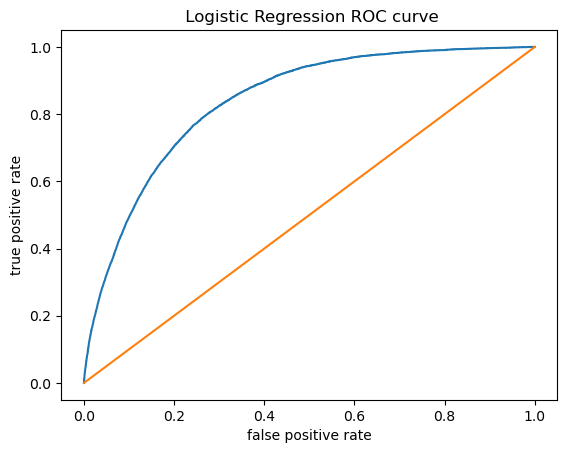

In [53]:
y_pred_test = log_final.predict(X_test)
y_pred_train = log_final.predict(X_train)

# plotting the ROC curve and printing the AUC score for the logistic model
print('=========== Logistic Regression AUC score ==========')
print(metrics.roc_auc_score(y_test,y_pred_test))
print('===============================================\n')
log_y_score = log_final.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,log_y_score)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(' Logistic Regression ROC curve')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


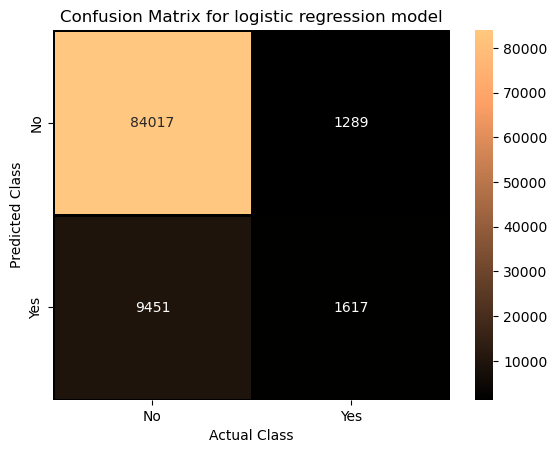

In [59]:
sns.heatmap(confusion_matrix(y_test, y_pred_test),
    annot = True,
    cmap = "copper",
    linewidths = 2,
    linecolor = "black",
    xticklabels = ['No','Yes'],
    yticklabels = ['No','Yes'],
    fmt = '.0F'
           )
plt.title('Confusion Matrix for logistic regression model')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')


In [11]:
# Getting coefficients
logi_coef = log_final.coef_
avg_coef = np.mean(logi_coef, axis=0)

# Feature names for plotting
feature_names = data['feature_names']

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': ave_coef})
coef_df = coeff_df.sort_values(by = 'Coefficient', ascending = False)

plt.figure(figsize=(8, 6))
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.grid(True)
plt.show()


NameError: name 'data' is not defined

### K-nearest Neighbors

In [12]:
# knn_train_score = {}
# knn_test_score = {}
# n_neighbors = np.arange(2, 15, 1)
# for neighbor in n_neighbors:
#     knn = KNeighborsClassifier(n_neighbors=neighbor)
#     knn.fit(X_train, y_train)
#     knn_train_score[neighbor]=knn.score(X_train, y_train)
#     knn_test_score[neighbor]=knn.score(X_test, y_test)

In [13]:
# plot the training and test scores

# Convert scores into a DataFrame
# scores_df = pd.DataFrame(
#     {'Neighbors': n_neighbors,
#      'Train Accuracy': [knn_train_score[n] for n in n_neighbors],
#      'Test Accuracy': [knn_test_score[n] for n in n_neighbors]}
#      )

# # Melt the DataFrame to make it suitable for Seaborn's lineplot
# knn_scores_df = pd.melt(scores_df, id_vars=['Neighbors'],
#                          var_name='Type', value_name='Accuracy')

# # Create the plot using Seaborn
# plt.figure(figsize = (8, 5))
# sns.lineplot(data = knn_scores_df, x = 'Neighbors',
#              y = 'Accuracy', hue = 'Type', marker='o')
# plt.title('KNN: Varying Number of Neighbors')
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Accuracy')
# plt.xlim(1, 31)
# plt.ylim(0.60, 0.90)
# plt.grid(True)
# plt.legend(title='Data Type')
# plt.show()

In [14]:
knn_param_grid = {
    'knn__n_neighbors': [1, 10, 20, 30],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 69)

knn_grid_search = GridSearchCV(knn_pipe,
                               knn_param_grid,
                               cv = cv,
                               verbose = 0,
                               scoring = roc_auc_scorer,
                               n_jobs = threads)

knn_grid_search.fit(X_train, y_train)

print("Best parameters:", knn_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(knn_grid_search.best_score_))

/var/data/python/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/var/data/python/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/var/data/python/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/var/data/python/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 30, 'knn__weights': 'distance'}
Best cross-validation score: 0.79


/var/data/python/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [15]:
best_knn = knn_grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
print("Test set accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

Test set accuracy: 0.89


In [18]:
# plot results
cv_results = pd.DataFrame(knn_grid_search.cv_results_)
uniform_results = cv_results[cv_results['param_knn__weights'] == 'uniform']
plt.figure(figsize=(10, 7))
plt.plot(uniform_results['param_knn__n_neighbors'], uniform_results['mean_train_score'], label='Train ROC AUC', marker='o')
# plt.plot(uniform_results['param_knn__n_neighbors'], uniform_results['mean_test_score'], label='Validation ROC AUC', marker='o')
plt.title('KNN Performance Evaluation with Varying Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'mean_train_score'

<Figure size 1000x700 with 0 Axes>